In [2]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd

In [2]:
df=pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\dataset\Majestic.csv")
df=df[['Track ID','TimeStamp','Type','X','Y']].dropna()
df['Track ID'] = df['Track ID'].astype(int)
df=df[df['Track ID']>=1]
df['Track ID'] = df['Track ID'].sort_values()
unique_tracks_per_type = df.groupby('Type')['Track ID'].nunique()
print(unique_tracks_per_type)
print(f'total {sum(unique_tracks_per_type)}')
print(df['TimeStamp'].max())


Type
 Bicycle           1
 Bus              61
 Car            1040
 Light Truck     203
 Motorcycle     3011
 Pedestrian     1069
 Tractor           1
 Tuk-Tuk        1740
 Van               9
Name: Track ID, dtype: int64
total 7135
5529.92


In [3]:
LT=df[df['Type']==' Light Truck']['Track ID'].unique()
pedRow=df[df['Type']==' Light Truck']['Track ID'].count()
df=df[df['Track ID'].isin(LT)]
df=df.sort_values(by=['Track ID','TimeStamp'])
ip_count=len(LT)
dt=0.16
Dx=np.zeros(len(df))
Dy=np.zeros(len(df))
dx=np.nan
dy=np.nan
i=0
while i<len(df):
    if (i==0):
        pass
    elif(df['Track ID'].iloc[i]!=df['Track ID'].iloc[i-1]):
        dx=np.nan
        dy=np.nan
    else:
        dx=df['X'].iloc[i]-df['X'].iloc[i-1]
        dy=df['Y'].iloc[i]-df['Y'].iloc[i-1]

    Dx[i]=(dx)
    Dy[i]=(dy)
    i+=1

df['dx']=Dx
df['dy']=Dy
df['vx']=df['dx']/dt
df['vy']=df['dy']/dt
df.to_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\Temp/LT.csv")

total Light Truck : 203
total fast LT (max) > 22 m/s : 15


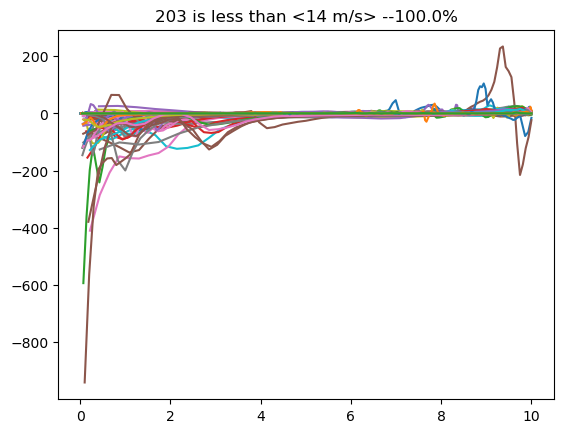

In [13]:
df=pd.read_csv(r"D:\T\test_codeEVT\Temp\LT.csv")
before= df['Type'].count()
LT=df[df['Type']==' Light Truck']['Track ID'].unique()
counter=0
fp=0
t=14
t2=22
print(f'total Light Truck : {len(LT)}')
for i in LT:
    y=df[df['Track ID']==i]['vy']
    x=np.linspace(0,10,len(y))
    plt.plot(x,y)
    if(y.mean()<t):
        counter+=1
    if (y.max()>t2):
        fp+=1

plt.title(f'{counter} is less than <{t} m/s> --{round(counter*100/len(LT),2)}%')
print(f'total fast LT (max) > {t2} m/s : {fp}')


In [14]:
dt=0.16
def kalman_1d(track_series, c=0.01, r=0.005):
    if np.isnan(track_series.iloc[0]):
        track_series = track_series.fillna(method='ffill').fillna(method='bfill')
    n = len(track_series)
    if n == 0:
        return np.array([])

    x = np.zeros(n)
    p = np.zeros(n)
    x_minus = np.zeros(n)
    p_minus = np.zeros(n)
    k_gain = np.zeros(n)

    x[0] = track_series.iloc[0]
    p[0] = 1

    for i in range(1, n):
        x_minus[i] = x[i - 1]
        p_minus[i] = p[i - 1] + c
        k_gain[i] = p_minus[i] / (p_minus[i] + r)
        x[i] = x_minus[i] + k_gain[i] * (track_series.iloc[i] - x_minus[i])
        p[i] = (1 - k_gain[i]) * p_minus[i]

    return x

c=0.001
r=0.001
for m in LT:
    track_df = df[df['Track ID'] == m]
    if track_df.empty:
        continue  # skip if no data
    nom = len(track_df)
    vy_s = kalman_1d(track_df['vy'], c=c, r=r)
    dy_s = dt * vy_s
    y_s = np.zeros(nom)
    y_s[0] = track_df['Y'].iloc[0]
    for i in range(1, nom):
        y_s[i] = y_s[i - 1] + dy_s[i]

    df.loc[track_df.index, 'vy_smooth'] = vy_s
    df.loc[track_df.index, 'dy_smooth'] = dy_s
    df.loc[track_df.index, 'y_smooth'] = y_s
for m in LT:
    track_df = df[df['Track ID'] == m]
    if track_df.empty:
        continue  # skip if no data
    nom = len(track_df)

    vx_s = kalman_1d(track_df['vx'], c=c, r=r)
    dx_s = dt * vx_s

    x_s = np.zeros(nom)
    x_s[0] = track_df['X'].iloc[0]
    for i in range(1, nom):
        x_s[i] = x_s[i - 1] + dx_s[i]

    df.loc[track_df.index, 'vx_smooth'] = vx_s
    df.loc[track_df.index, 'dx_smooth'] = dx_s
    df.loc[track_df.index, 'x_smooth'] = x_s



C:\Users\IST LAB 2\AppData\Local\Temp\ipykernel_23808\3789068844.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  track_series = track_series.fillna(method='ffill').fillna(method='bfill')
C:\Users\IST LAB 2\AppData\Local\Temp\ipykernel_23808\3789068844.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  track_series = track_series.fillna(method='ffill').fillna(method='bfill')
C:\Users\IST LAB 2\AppData\Local\Temp\ipykernel_23808\3789068844.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  track_series = track_series.fillna(method='ffill').fillna(method='bfill')
C:\Users\IST LAB 2\AppData\Local\Temp\ipykernel_23808\3789068844.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future versi

In [15]:
dt=0.16
Dvx=np.zeros(len(df))
Dvy=np.zeros(len(df))
dvx=np.nan
dvy=np.nan
i=0
while i<len(df):
    if (i==0):
        pass
    elif(df['Track ID'].iloc[i]!=df['Track ID'].iloc[i-1]):
        dvx=np.nan
        dvy=np.nan
    else:
        dvx=df['vx_smooth'].iloc[i]-df['vx_smooth'].iloc[i-1]
        dvy=df['vy_smooth'].iloc[i]-df['vy_smooth'].iloc[i-1]

    Dvx[i]=(dvx)
    Dvy[i]=(dvy)
    i+=1

df['dvx']=Dvx
df['dvy']=Dvy
df['ax']=df['dvx']/dt
df['ay']=df['dvy']/dt
# df.to_csv(r"D:\T\test_codeEVT\nd2")
HA=np.zeros(len(df))
ha=np.nan

i=0
while i<len(df):
    if (i==0):
        pass
    elif(df['Track ID'].iloc[i]!=df['Track ID'].iloc[i-1]):
        ha=np.nan
    else:
        ha=np.degrees(np.arctan2(df['vy_smooth'].iloc[i], df['vx_smooth'].iloc[i])) % 360


    HA[i]=(ha)
    i+=1

df['HA']=HA

# df.to_csv(r"D:\T\test_codeEVT\nd2")

% loss of data 1.4578527398555394
total LT : 203
52886
52115


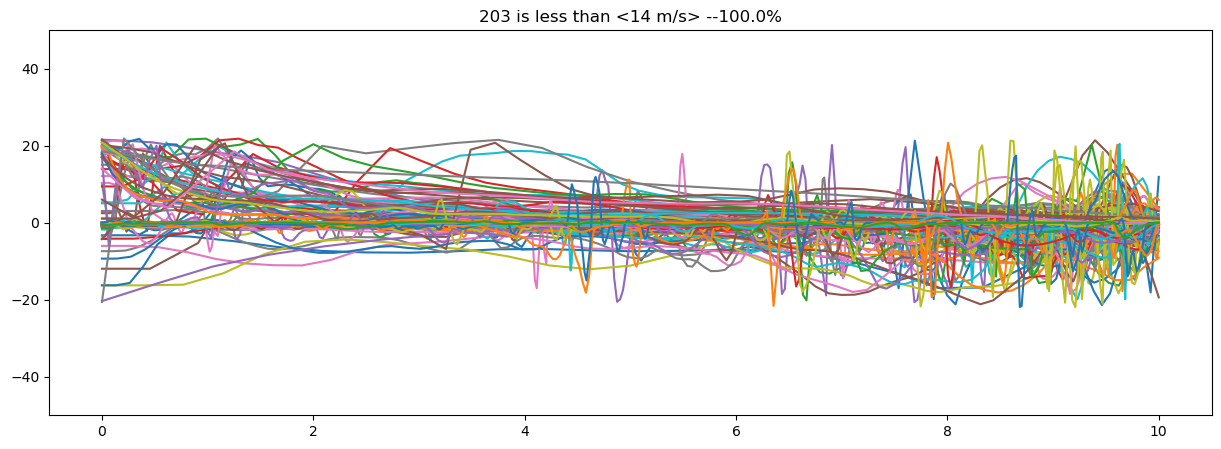

In [16]:
df = df[df['vx_smooth'].abs() <= t2]
df = df[df['vy_smooth'].abs() <= t2]
after= df['Track ID'].count()
print(f'% loss of data {100- after*100/before}')

counter=0
fp=0




plt.figure(figsize=(15,5))
print(f'total LT : {len(LT)}')
for i in LT:
    y=df[df['Track ID']==i]['vx_smooth']
    x=np.linspace(0,10,len(y))
    plt.plot(x,y)
    if(y.mean()<t):
        counter+=1
    if (y.max()>t2):
        fp+=1
plt.ylim(-50,50)
plt.title(f'{counter} is less than <{t} m/s> --{round(counter*100/len(LT),2)}%')

print(before)
print(after)

In [17]:
# df.to_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\LightTruck_smooth.csv")

total LT : 203


Text(0.5, 1.0, '203 is less than <14 m/s> --100.0%')

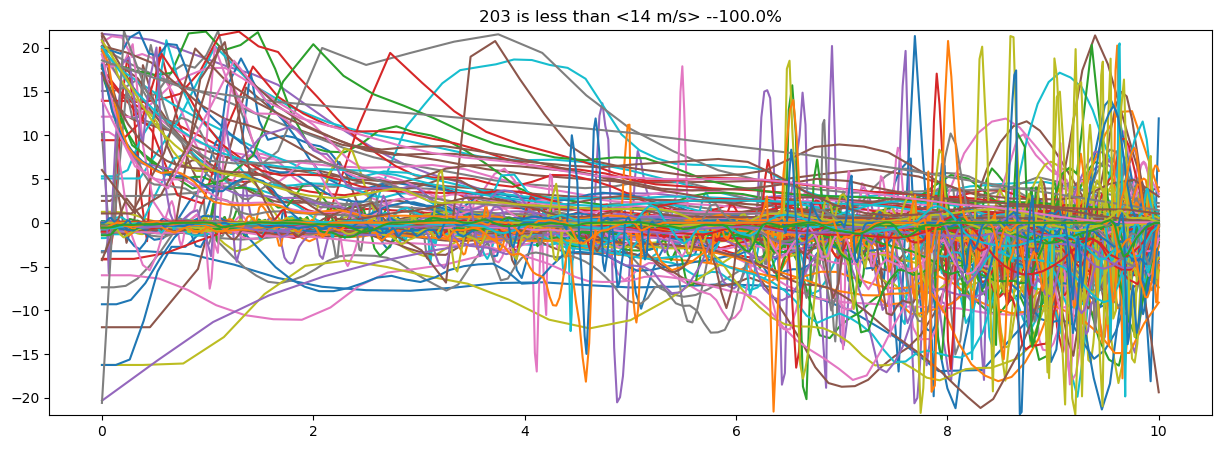

In [18]:
counter=0
fp=0
plt.figure(figsize=(15,5))
print(f'total LT : {len(LT)}')
for i in LT:
    y=df[df['Track ID']==i]['vx_smooth']
    x=np.linspace(0,10,len(y))
    plt.plot(x,y)
    if(y.mean()<t):
        counter+=1
    if (y.max()>t2):
        fp+=1
plt.ylim(-22,22)
plt.title(f'{counter} is less than <{t} m/s> --{round(counter*100/len(LT),2)}%')

In [19]:
import pandas as pd
# df=pd.read_csv(r"C:\Users\Tusha\Visual Studio Codes\test_codeEVT\smoothen_data\LightTruck_smooth.csv")
df['speed']=((df['vx_smooth']**2+df['vy_smooth']**2)**0.5)
t=22
f=df[df['speed']>t]
len(f)
len(df)
print(f'speed greater than {t}m/s ={len(f)} -- {len(f)/len(df)} %')


speed greater than 22m/s =150 -- 0.0028782500239854167 %


In [20]:
df=df[df['speed']<t]
df=df[['Track ID', 'TimeStamp', 'Type', 'X', 'Y', 'dx', 'dy',
       'vx', 'vy', 'vy_smooth', 'dy_smooth', 'y_smooth', 'vx_smooth',
       'dx_smooth', 'x_smooth', 'dvx', 'dvy', 'ax', 'ay', 'HA']]
df.to_csv(r"D:\T\test_codeEVT\nd/LightTruck_smooth.csv")

In [21]:

df=pd.read_csv(r"D:\T\test_codeEVT\nd/LightTruck_smooth.csv")
# print(before)
after= len(df)
print(f'% loss of data {100- after*100/before}')
print(before)
print(after)

% loss of data 1.7414816775706186
52886
51965
